# Recursive Forecasting

Now let's use our trained models to predict the future more than the trained horizon.  
We are using a recursive approach here. The model we use is trained to predict 1 day into the future based on week's data.  
We will iteratively call our model till it forecast until the requested no. of days into the future.  
At each iteration we will discard the oldest 24 steps of data and append the models predictions to it. for the exogeneous features we are using the values from the last step of initial input sequence

First we will load our test dataset and load the model as usual

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df_test = pd.read_csv('./dataset/test.csv')

scaler_r = MinMaxScaler()
scaler_c = MinMaxScaler()

scaler_r.fit(df_test[['registered']])
scaler_c.fit(df_test[['casual']])


df_test['registered_s'] = scaler_r.transform(df_test[['registered']])
df_test['casual_s'] = scaler_c.transform(df_test[['casual']])

df_test.drop(['Unnamed: 0','casual','registered'],axis=1,inplace=True)

import numpy as np


def create_dataset(data, feature_columns, target_columns, lookback_window, horizon, shift):
    """
    Transforms a time series DataFrame into input-target pairs for a deep learning model.

    Args:
        data (pd.DataFrame): The input DataFrame.
        feature_columns (list): List of column names to use as input features (X).
        target_columns (list): List of column names to use as target variables (Y).
        lookback_window (int): The number of past time steps to use as input (X).
        horizon (int): The number of future time steps to predict (Y).
        shift (int): The number of steps to shift the window for each new sample.

    Returns:
        tuple: A tuple containing two NumPy arrays, X (inputs) and Y (targets).
    """
    X, Y = [], []
    for i in range(0, len(data) - lookback_window - horizon + 1, shift):
        # Extract the input features (X) for the current window
        x_start = i
        x_end = i + lookback_window
        X.append(data.iloc[x_start:x_end][feature_columns].values)

        # Extract the target variables (Y) for the forecast horizon
        y_start = i + lookback_window
        y_end = y_start + horizon
        Y.append(data.iloc[y_start:y_end][target_columns].values)
    
    return np.array(X), np.array(Y)

In [2]:
import yaml

def load_config(filepath):
    """
    Loads a YAML configuration file from the specified filepath.

    Args:
        filepath (str): The path to the YAML file.

    Returns:
        dict: The configuration as a dictionary.
    """
    try:
        with open(filepath, 'r') as file:
            config = yaml.safe_load(file)
        return config
    except FileNotFoundError:
        print(f"Error: The file at {filepath} was not found.")
        return None
    except yaml.YAMLError as exc:
        print(f"Error parsing YAML file: {exc}")
        return None

# Load the configuration from the YAML file
config_file = 'config.yaml'
model_config = load_config(config_file)

In [3]:
LOOKBACK_WINDOW = model_config['dataset']['lookback_window']  
FORECAST_HORIZON = model_config['dataset']['forecast_horizon'] 
SHIFT = 24
BATCH_SIZE = model_config['dataset']['batch_size']
NUM_FEATURES = model_config['model']['num_features']
NUM_TARGETS = model_config['model']['num_targets']

feature_columns = model_config['data']['feature_columns']

target_columns = model_config['data']['target_columns']

X_test, Y_test = create_dataset(df_test, feature_columns, target_columns, LOOKBACK_WINDOW, FORECAST_HORIZON, SHIFT)



In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert NumPy arrays to PyTorch Tensors
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(Y_test)

test_dataset = TensorDataset(X_test, y_test)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
from model import CNN_LSTMForecaster

model = CNN_LSTMForecaster(
        num_features=NUM_FEATURES,
        hidden_size=64,
        num_layers=1,
        output_size=FORECAST_HORIZON * NUM_TARGETS
    )

device = 'cuda' if torch.cuda.is_available() else 'cpu'

try:
    model.load_state_dict(torch.load('models/cnn_lstm_7f_best.pth', map_location=device))
    print("Successfully loaded models.")
except FileNotFoundError:
    print("Error: 'best_model.pth' not found. Please train the model first.")

## Forecasting the Futre using single Input Sequence

Now let's select a random sample from our dataset and predict the future. 

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


def predict_future(model, input_sequence, forecast_horizon_days, device='cpu'):
    """
    Performs multi-step forecasting using a recursive strategy.

    Args:
        model (nn.Module): The trained model.
        input_sequence (torch.Tensor): The initial input sequence of shape (1, lookback_window, num_features).
        forecast_horizon_days (int): The number of future days (24-hour periods) to predict.
        device (str): The device to run on.

    Returns:
        torch.Tensor: The full sequence of future predictions of shape (total_predictions, num_targets).
    """
    model.eval()
    model.to(device)
    
    # Clone the initial input sequence to avoid modifying the original data
    current_input = input_sequence.clone().detach().to(device)
    
    # The model predicts a full 24-hour block at a time
    output_horizon = 24
    
    # number of targets (e.g., casual and registered)
    num_targets = 2
    
    # Store all future predictions
    all_predictions = []
    
    with torch.no_grad():
        for i in range(forecast_horizon_days):

            # Get the model's 24-hour forecast from the model
            prediction = model(current_input)

            prediction = prediction.squeeze() #getting rid of additional dimension due to batches
            all_predictions.append(prediction.cpu())

        # Prepare the next input sequence for the recursive step
            
            # Remove the oldest 24 time steps from the lookback window
            new_input = current_input[:, output_horizon:, :].clone()
            
            # Create a tensor for the new 24 steps to be appended
            new_steps = torch.zeros(1, output_horizon, current_input.size(2)).to(device)
            
            # Fill the new steps with the predicted target values
            # The last 2 features of the inputs are the outputs of the model
            new_steps[:, :, -num_targets:] = prediction.unsqueeze(0)
            
            # Fill the exogenious features in the new steps with the last known values
            for j in range(new_steps.size(2) - num_targets):
                new_steps[:, :, j] = new_input[:, -1, j].clone().detach().unsqueeze(0).unsqueeze(0)
            
            # Concatenate the new steps to the end of the sliding window
            current_input = torch.cat((new_input, new_steps), dim=1)

    return torch.cat(all_predictions, dim=0)


def get_random_sample(X_data, Y_data , forecast_horizon):
    """
    Gets a random input sequence and its corresponding true future values.

    Args:
        X_data (np.ndarray): The input features dataset.
        Y_data (np.ndarray): The target values dataset.

    Returns:
        tuple: A tuple containing:
            - The random input sequence as a PyTorch Tensor.
            - The corresponding true future values as a NumPy array.
    """
    # Get a random index
    random_idx = np.random.randint(0, len(X_data)-7)
    
    # Select the corresponding samples
    random_input_sequence = X_data[random_idx:random_idx+1, :, :]
    true_future_values = Y_data[random_idx:random_idx+forecast_horizon].reshape(-1,2)
    
    # Convert the input sequence to a PyTorch tensor
    input_tensor = torch.from_numpy(random_input_sequence).float()
    
    return input_tensor, true_future_values



We can set the no. of days to predict in the future using the variable forecast_days.

In [ ]:
forecast_days = 5

x,y = get_random_sample(X_test, Y_test , forecast_days)
preds = predict_future(model,x,forecast_days)
preds = preds.detach().numpy()

preds_c = scaler_c.inverse_transform(preds[:,0].reshape(-1, 1)).flatten()
preds_r = scaler_r.inverse_transform(preds[:,1].reshape(-1, 1)).flatten()

actual_c = scaler_c.inverse_transform(y[:,0].reshape(-1, 1)).flatten()
actual_r = scaler_r.inverse_transform(y[:,1].reshape(-1, 1)).flatten()

Now let's plot the prediction of the model vs Actual values to see theperformance of our model

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_16260\2394678712.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


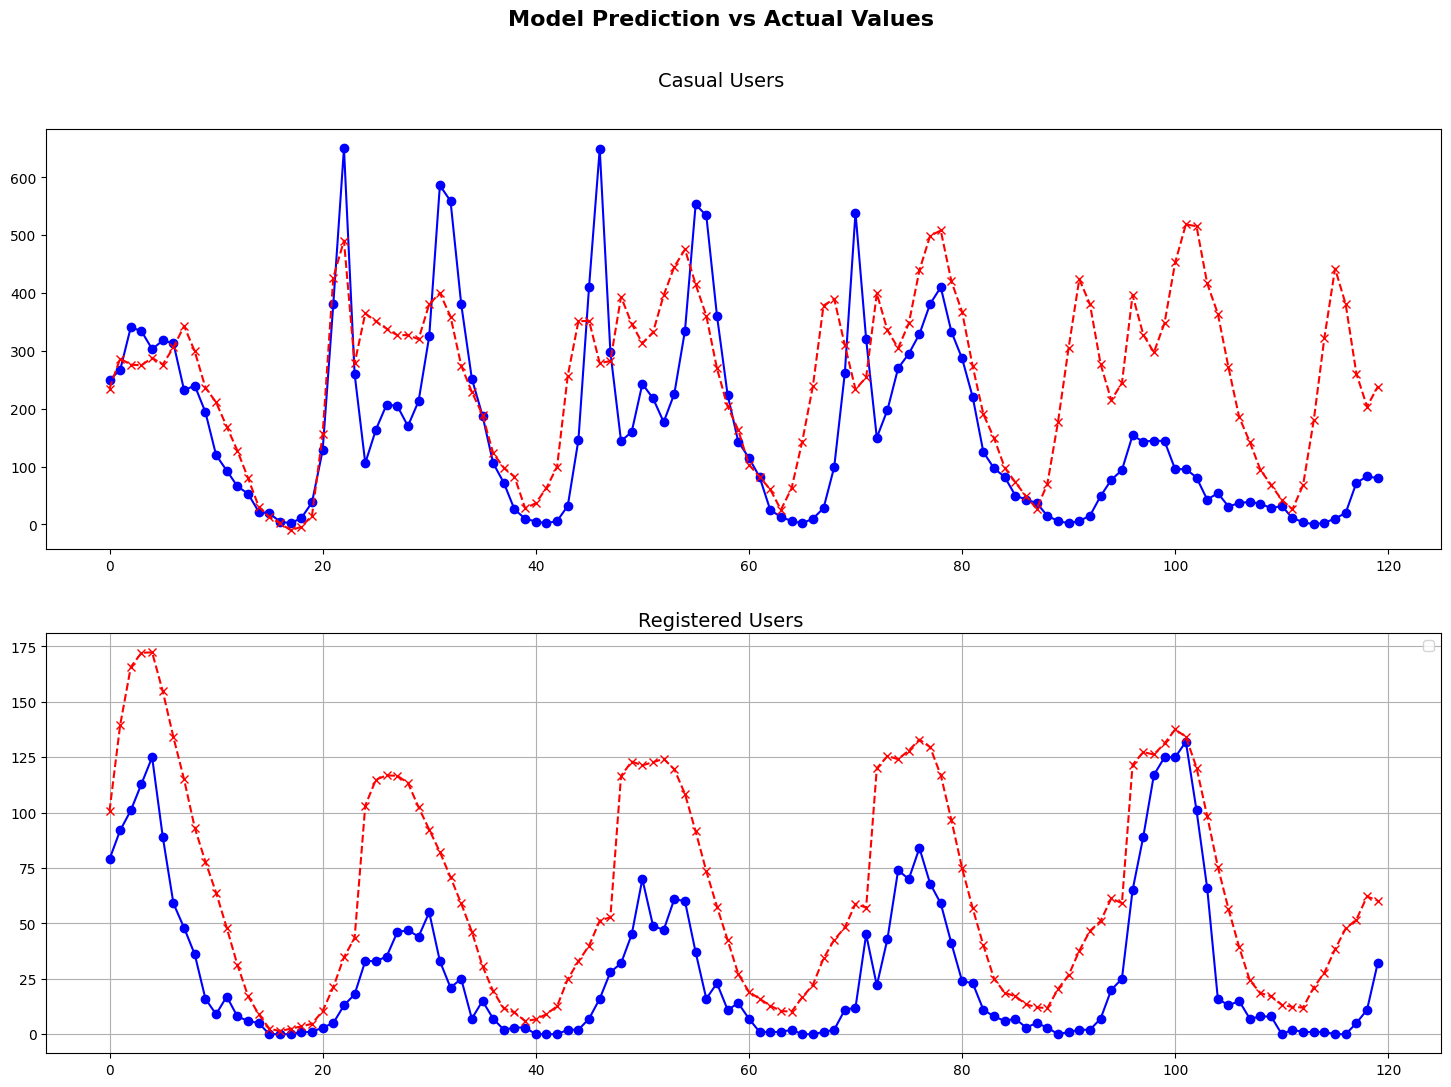

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18,12))
fig.suptitle("Model Prediction vs Actual Values", fontsize=16, fontweight='bold')
plt.subplot(211)
plt.plot(actual_r, color='blue', marker='o', label='Actual')
plt.plot(preds_r, color='orange', marker='x', label = 'Prediction')

plt.subplot(212)
plt.plot(actual_c, color='blue', marker='o',label='Actual')
plt.plot(preds_c, color='orange',  marker='x', label = 'Prediction')

_ = fig.text(0.5, 0.92, 'Casual Users', ha='center', va='center', fontsize=14)
_ = fig.text(0.5, 0.47, 'Registered Users', ha='center', va='center', fontsize=14)
plt.grid(True)
plt.legend(loc='best')
plt.subplots_adjust(hspace=0.2)
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 18), sharey=False)



# Plot Casual Users
plot_df[['Casual Actual', 'Casual Predicted']].plot(ax=axes[0], title='Casual Users: Filtered Predictions vs. Actuals')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Scaled Bike Count')
axes[0].grid(True)

# Plot Registered Users
plot_df[['Registered Actual', 'Registered Predicted']].plot(ax=axes[1], title='Registered Users: Filtered Predictions vs. Actuals')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Scaled Bike Count')
axes[1].grid(True)

plt.tight_layout()
plt.show()